In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def bacteria(params, uc):
    a, b, g, u_thresh, n = params
    return a + ((b * np.power(uc, n)) / (np.power(u_thresh, n) + np.power(uc, n))) - (g * uc)

In [3]:
def bacteria_particle(params, uc, ue, d1, d2, cells):
    duc = (bacteria(params, uc) + d1 * ue - d2 * uc) * cells
    due = (-d1 * ue + d2 * uc) * cells
    return duc, due

In [4]:
def plot_state(x, y, z1, z2, z3, count, save):
    plt.figure(figsize=(18, 4))
    titles=['uc','ue','cells']
    for idx, z in enumerate([z1, z2, z3]):
        plt.subplot(1, 3, idx+1)
        plt.scatter(x, y, c=z, s=15)
        plt.title(titles[idx], size=15)
        plt.colorbar()
    if save == 'save':
        plt.savefig('out_' + str(count) + '.png')
    else:
        plt.show()
    return   

In [5]:
def verlet(x, y, r, e):
    neighbors = np.zeros((50, 50), dtype = 'object')
    kernel = np.zeros((50, 50), dtype = 'object')
    dim = np.shape(x)
    for i in range(dim[0]):
        for j in range(dim[1]):
            dist = np.sqrt(np.square(x[i,j] - x) + np.square(y[i,j] - y))
            neighbors[i, j] = np.transpose(np.where(dist <= r))
            kernel[i, j] = (1 / (4 * (np.pi * np.square(e)))) * np.exp(-(np.square(dist[dist <= r]) / (4 * np.square(e))))
    return neighbors, kernel

In [6]:
def pse(nest, De, Vp, ge, e):
    k_sum = np.zeros((50, 50))
    dim = np.shape(nest)
    for i in range(dim[1]):
        for j in range(dim[2]):
            k_sum[i, j] = np.sum((np.array([nest[3][k[0], k[1]] for k in nest[5][i, j]]) - nest[3][i, j]) * nest[6][i, j]) 
    due_diff = k_sum * Vp * De / np.square(e)
    due_deg = -ge * nest[3]
    return due_diff + due_deg

In [7]:
params=np.array([1, 100, 0.1, 5, 10])           # rxn paramerters: a, b, g, u_thresh, n
De = 1                                          # diffusion coefficient of ue
d1 = 0.25
d2 = 2.5
ge = 0                                          # external degradation of AHL
T = 200                                         # max time
h = 1                                           # particle spacing
Vp = h ** 2
dt = (h ** 2)/(4 * De)                          # time step
e = h                                           # kernel width
r = np.sqrt(2)                                  # radius of interaction
particles = np.arange(0+(h/2),51-(h/2),h)       # create mesh of particles
x, y = np.meshgrid(particles, particles)
uc, ue = np.zeros((50, 50)), np.zeros((50, 50)) # initial concentrations
cells = np.zeros((50, 50))                      # bacterium count in each particle
cells[24, 24] = 1                               # add a bacterium in the grid
cells[20, 20] = 1
cells[32, 26] = 1
cells[35, 30] = 1
cells[24, 26] = 1
cells[25, 31] = 1
cells[27, 26] = 1
cells[18, 40] = 1
cells[30, 35] = 1
uc[24, 24] = 150                                # initial AHL concentration of bacteria in center

In [8]:
neighbors, kernel = verlet(x, y, r, e)                     # get neighbor and kernel array
nest=np.array([x, y, uc, ue, cells, neighbors, kernel])    # compile verlet list

In [9]:
t = 0
count = 0
while t < T:
    due_e = pse(nest, De, Vp, ge, e) * dt
    duc_b, due_b = bacteria_particle(params, nest[2], nest[3], d1, d2, nest[4])
    duc_b = duc_b * dt
    due_b = due_b * dt
    nest[2] = nest[2] + duc_b
    nest[3] = nest[3] + due_e + due_b
    #if count % 20 == 0:
    #    plot_state(nest[0], nest[1], nest[2], nest[3], nest[4], count, 'save')
    t = t + dt
    count = count + 1

/Users/gonzales/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


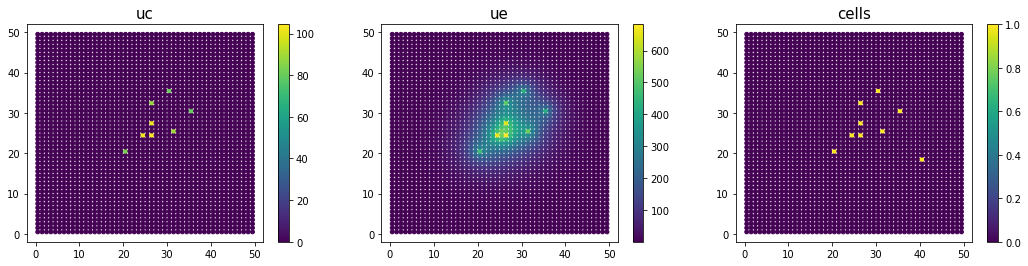

In [11]:
plot_state(nest[0], nest[1], nest[2], nest[3], nest[4], count, 'show')